In [1]:
using Meiran
using LinearAlgebra
using Tonari
using Plots
using Random

rng = MersenneTwister(1234);

Define the power spectral densities for the two processes and the cross-spectral density between them 

In [2]:
p1 = SingleBendingPowerLaw(1.0, 0.30, 4e-2, 3.5)
p2 = SingleBendingPowerLaw(1.0, 0.550, 1e-2, 2.95)
Δϕ = ConstantTimeLag(5.4)
cs = CrossSpectralDensity(p1, p2, Δϕ)

T = 320.0
Δt = 1.0
t = 0.0:Δt:T-Δt
S_low, S_high = 5, 5

f0, fM = 1 / T / S_low, 1 / (2Δt) * S_high
J = 1000

1000

In [3]:
σ_X₁², σ_X₂² = zeros(length(t)), zeros(length(t))
Σ = BlockMatrix_from_cs(cs, t, σ_X₁², σ_X₂², f0, fM, J)


BlockCovarianceMatrix([0.12193582754620931 0.11835527694467249 … 0.000450293068044941 0.00044641437975734234; 0.11835527694467249 0.12193582754620931 … 0.0004545083703408268 0.000450293068044941; … ; 0.000450293068044941 0.0004545083703408268 … 0.12193582754620931 0.11835527694467249; 0.00044641437975734234 0.000450293068044941 … 0.11835527694467249 0.12193582754620931], [0.048527950525739286 0.050937347515505015 … 0.0007641984245897684 0.00075764827291367; 0.04613207897073084 0.048527950525739286 … 0.000770875980920188 0.0007641984245897684; … ; 0.0006951083978590463 0.0007013198659351132 … 0.048527950525739286 0.050937347515505015; 0.0006889949794873176 0.0006951083978590463 … 0.04613207897073084 0.048527950525739286], [0.048527950525739286 0.04613207897073084 … 0.0006951083978590463 0.0006889949794873176; 0.050937347515505015 0.048527950525739286 … 0.0007013198659351132 0.0006951083978590463; … ; 0.0007641984245897684 0.000770875980920188 … 0.048527950525739286 0.04613207897073084; 

In [5]:
sanity_checks(Σ)

In [4]:
L₁₁, L₂₁, L₂₂ = cholesky(Σ)

([0.34919310924789065 0.0 … 0.0 0.0; 0.3389393255771625 0.0839997685919881 … 0.0 0.0; … ; 0.0012895244955285756 0.00020759351845171494 … 0.06323830880829392 0.0; 0.0012784169215677012 0.000202230305238869 … 0.10532502970946347 0.06323830867460495], [0.13897167280952702 -0.01155819952762281 … 0.00011578969432466676 0.0001149293943840011; 0.1458715712495484 -0.010876952041398751 … 0.00011270610591227847 0.00011271390325108186; … ; 0.002188469372250033 0.00034663961974608305 … 0.019504190785816795 0.018354091217332807; 0.002169711408525587 0.00034283312406383545 … 0.0206794358642178 0.019504183779004237], [0.12735492013696234 0.0 … 0.0 0.0; 0.11752677312131095 0.013008425370400823 … 0.0 0.0; … ; 0.0006378399800208026 0.00017279848077469596 … 0.0035515664843867975 0.0; 0.0006460558283909702 0.0001802999524883809 … -0.0002288407067942099 0.0035529030006948422])

In [7]:
n_samples = 50
y = randn(rng, length(t), 2,n_samples)
y₁, y₂ = y[:,1,:], y[:,2,:]

([1.2073639368384002 -0.22886273890692777 … -1.9154555801784898 0.38148710686460985; 0.05254995578624361 -0.8053553437396058 … -0.6511427062266666 -0.5876660653276774; … ; 0.10879634695775504 0.006312387097520237 … 0.6536869194971985 -0.6707773557727003; 0.46024621240085756 0.5742800086273186 … -0.8279326621350986 1.0292056696881784], [-0.07143219667300672 -0.8008384898103452 … -0.655675921138979 -0.346300237380713; -0.11635137074667383 -0.9204643201041688 … -0.34248232957661784 0.8577442081302135; … ; 0.2621993590359851 0.6287391308363491 … 0.4157597338912951 -0.791781678646589; -1.1261874915587835 0.4130486062188851 … 0.4980127817213153 1.6506058650248232])

In [8]:
x₁_sim = [L₁₁ * y₁[:,i] for i in 1:n_samples];
x₂_sim = [L₂₁ * y₁[:,i] + L₂₂ * y₂[:,i]  for i in 1:n_samples];

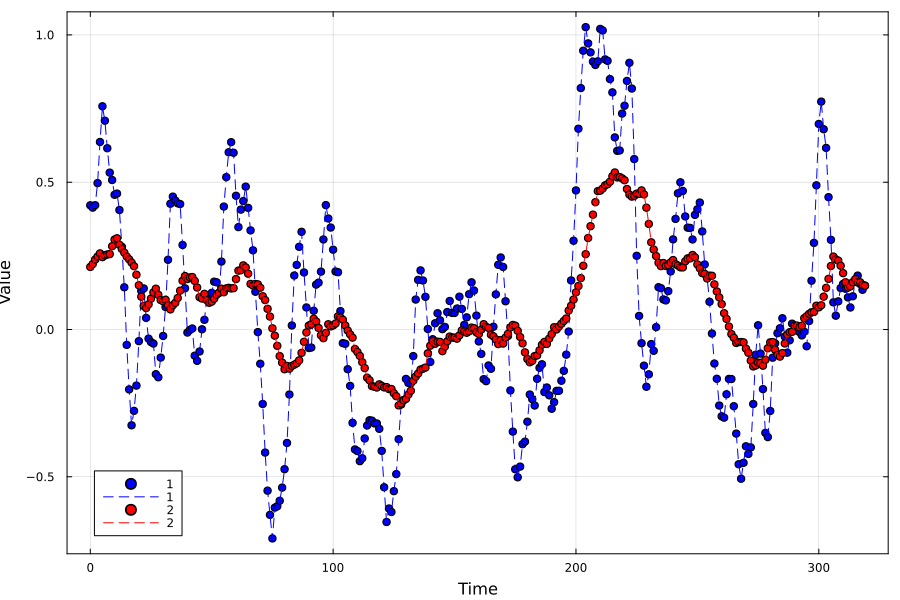

In [9]:
k = 1
scatter(t,x₁_sim[k],label="1", color="blue",framestyle=:box,size=(900,600),xlabel="Time",ylabel="Value")
plot!(t,x₁_sim[k],label="1", color="blue", linestyle=:dash)
scatter!(t,x₂_sim[k],label="2", color="red")
plot!(t,x₂_sim[k],label="2", color="red", linestyle=:dash)

In [10]:
f, γ², Δφ, γ²_err, Δφ_err, Δτ, Δτ_err, P̄₁, P̄₂, C̄ = cross_periodogram(t, mapreduce(permutedims,vcat,x₁_sim)', mapreduce(permutedims,vcat,x₂_sim)')

┌ Info: Multiple time series detected. Computing the average cross-periodogram.
└ @ Tonari /home/mehdy/github/Tonari.jl/src/periodogram.jl:136


([0.003125, 0.00625, 0.009375000000000001, 0.0125, 0.015625, 0.018750000000000003, 0.021875000000000002, 0.025, 0.028125, 0.03125  …  0.47187500000000004, 0.47500000000000003, 0.478125, 0.48125, 0.484375, 0.48750000000000004, 0.49062500000000003, 0.49375, 0.496875, 0.5], [0.9816749537062817; 0.9815273973061243; … ; 0.028509889215675023; 0.07095562995837522;;], [-0.09671241303417497; -0.19181869021285664; … ; -0.1123103560258087; 0.0;;], [0.0036312732585229903; 0.003660237772776112; … ; 0.032806971747117275; 0.049494835093735534;;], [0.0018495293400393057; 0.001864562203165143; … ; 0.5753612632258085; 0.34877313556916295;;], [-4.925522749674878; -4.884622835966256; … ; -0.03597433624536974; 0.0;;], [0.09419575579543886; 0.04748068661376757; … ; 0.18429502210009474; 0.11101793708698406;;], [535.3225585552392; 569.8898837667246; … ; 0.17683247902976082; 0.1275806290254495;;], [464.3702041423748; 327.84256296036466; … ; 0.022801647839832566; 0.013762405574847956;;], ComplexF64[491.68797308

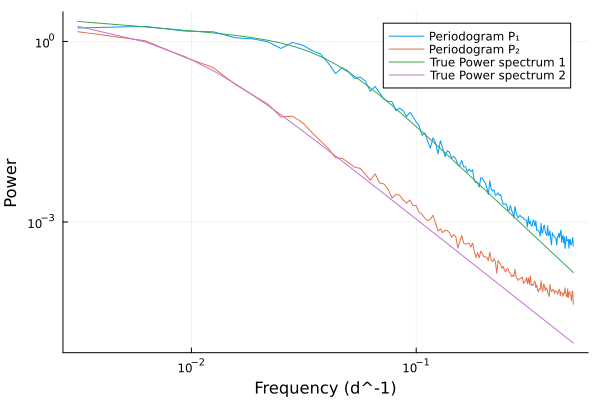

In [11]:
plot(f,P̄₁/length(f)/2,label="Periodogram P₁",xscale=:log10,yscale=:log10)
plot!(f,P̄₂/length(f)/2,xscale=:log10,yscale=:log10,label="Periodogram P₂",xlabel="Frequency (d^-1)",ylabel="Power")
plot!(f,p1(f),xscale=:log10,yscale=:log10,label="True Power spectrum 1")
plot!(f,p2(f),xscale=:log10,yscale=:log10,label="True Power spectrum 2")

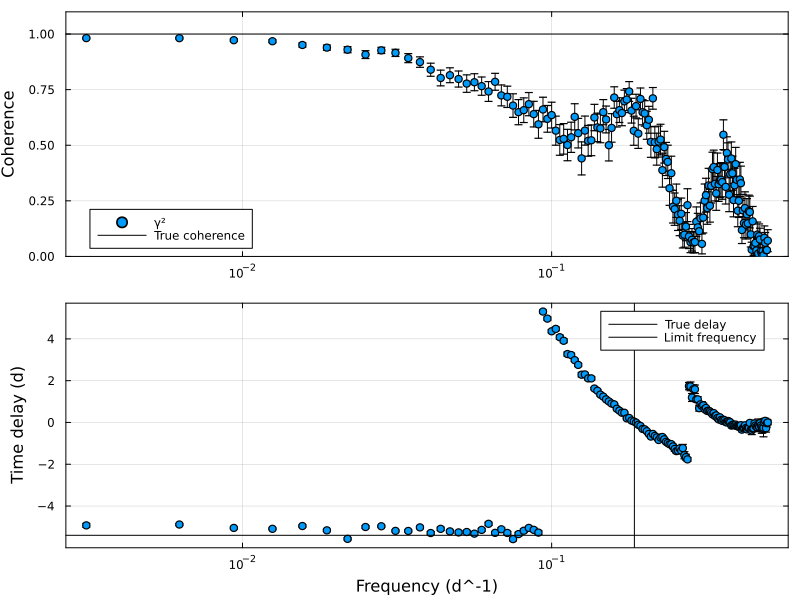

In [12]:
l = @layout [a; b]
pl1 = scatter(f, γ², yerr=γ²_err, label="γ²", xscale=:log10,ylims=(0,1.1),ms=4,ylabel="Coherence",link=:x, framestyle=:box)
pl1 = hline!([1.0],color=:black,label="True coherence")
pl2 = scatter(f, Δτ, yerr=Δτ_err, xscale=:log10, ylabel="Time delay (d)",xlabel="Frequency (d^-1)",link=:x, framestyle=:box,label=nothing)
pl2 = hline!([-cs.Δφ.Δτ ],color=:black,label="True delay")
pl2 = vline!([1/cs.Δφ.Δτ ],color=:black,label="Limit frequency")
plot(pl1, pl2, layout=l,size=(800,600))